In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, auc
from rdkit import Chem


matplotlib.rcdefaults()
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 100

pd.set_option("display.max_columns", None)

In [2]:
# title suffix
title_suffix = "S1PR1"

# Files we are processing
file_path_sdf_active = "./S1PR1/docking/S1PR1_active_docking_lib_sorted.sdf"
file_path_sdf_decoy = "./S1PR1/docking/S1PR1_decoy_docking_lib_sorted.sdf"
file_path_strain_active = "./S1PR1/strain/S1PR1_active_docking_lib_sorted.csv"
file_path_strain_decoy = "./S1PR1/strain/S1PR1_decoy_docking_lib_sorted.csv"

In [3]:
def sdf_to_df(args):
    """
    Load molecules and their properties from an SDF file into a DataFrame.

    Example usage: df=sdf_to_df(("./ADRB1/docking/ADRB1_active_docking_lib.sdf", "active"))

    Note that this function was originally intended to be used with the `multiprocessing` module, so the arguments are passed as a tuple.

    Will likely be updated later.

    """
    file, active_status = args  # Unpack the tuple of arguments

    # Create a molecule supplier
    mol_supplier = Chem.MultithreadedSDMolSupplier(file, numWriterThreads=8)

    # Load the molecules and their properties into a list
    molecules = []
    first_mol = True
    for mol in mol_supplier:
        if mol is not None:
            if first_mol:
                # Get properties as dictionary only for the first molecule
                props = mol.GetPropsAsDict()
                keys = props.keys()
                first_mol = False
            else:
                # For the rest of the molecules, get properties directly
                props = {key: mol.GetProp(key) for key in keys if mol.HasProp(key)}

            props["Title"] = mol.GetProp("_Name")
            props["Mol"] = mol
            props["Activity"] = 1 if active_status == "active" else 0
            molecules.append(props)

    # Convert the list into a DataFrame
    df = pd.DataFrame(molecules)

    # Reorder the DataFrame columns
    cols = ["Title", "Mol", "Activity"] + [
        col for col in df.columns if col not in ["Title", "Mol", "Activity"]
    ]
    df = df[cols]
    df = df.rename(columns={"Title": "Molecule_Name"})

    # Convert 'r_i_docking_score' to numeric, coercing errors to NaN
    df["r_i_docking_score"] = pd.to_numeric(df["r_i_docking_score"], errors="coerce")

    # Print 'Molecule_Name' and 'r_i_docking_score' for entries that could not be converted
    non_convertible_entries = df[df["r_i_docking_score"].isna()]
    for _, row in non_convertible_entries.iterrows():
        print(
            f"Molecule_Name: {row['Molecule_Name']}, r_i_docking_score: {row['r_i_docking_score']}"
        )

    # Drop rows with non-convertible 'r_i_docking_score'
    df = df.dropna(subset=["r_i_docking_score"])

    # Convert 'r_i_docking_score' to int64
    df["r_i_docking_score"] = df["r_i_docking_score"].astype("float64")

    return df

In [4]:
active_sdf = sdf_to_df((file_path_sdf_active, "active"))
decoy_sdf = sdf_to_df((file_path_sdf_decoy, "inactive"))

In [5]:
#TODO replace with a check for duplicates and sys exit with message
duplicates_actives = active_sdf["Molecule_Name"].duplicated()
print(any(duplicates_actives))
duplicates_decoys = decoy_sdf["Molecule_Name"].duplicated()
print(any(duplicates_decoys))

False
False


In [6]:
# from old code, probably fine but not optimal
def concatenate_csv_files(file_list):
    """
    Concatenates multiple strain CSV files into a single dataframe.
    Only the first five columns are kept for now.

    Args:
        file_list (list): A list of file paths to the CSV files.

    Returns:
        pandas.DataFrame: The concatenated dataframe.

    """
    # Specify the column names
    column_names = [
        "Molecule_Name",
        "Total_E",
        "Lower_Bound",
        "Upper_Bound",
        "Num_Torsion_Patterns",
    ]

    # List to hold dataframes
    df_list = []

    # Loop over each file in the list
    for file in file_list:
        # Import the CSV file as a df, using only the first five columns of the CSV file
        df = pd.read_csv(file, usecols=range(5), names=column_names, header=0)
        df_list.append(df)

    # Concatenate all dataframes in the list
    final_df = pd.concat(df_list, ignore_index=True)

    return final_df

In [7]:
active_strain = concatenate_csv_files([file_path_strain_active])
decoy_strain = concatenate_csv_files([file_path_strain_decoy])

In [8]:
#TODO replace with a check for duplicates and sys exit with message
duplicates_actives = active_strain["Molecule_Name"].duplicated()
print(any(duplicates_actives))
duplicates_decoys = decoy_strain["Molecule_Name"].duplicated()
print(any(duplicates_decoys))

False
False


In [9]:
# only keep as commented for debug
# pre_merge = [active_sdf, decoy_sdf, active_strain, decoy_strain]

# for df in pre_merge:
#     print(df.shape)

In [10]:
active_data=pd.merge(active_sdf, active_strain, on='Molecule_Name')
decoy_data=pd.merge(decoy_sdf, decoy_strain, on='Molecule_Name')

In [11]:
# #only keep as commented for debug
# post_merge = [active_data, decoy_data]

# for df in post_merge:
#     print(df.shape)

In [12]:
all_data = pd.concat([active_data, decoy_data])

#print(all_data.shape)

In [13]:
def plot_density(df, title_suffix):
  # Hardcoded column names
  activity_col = 'Activity'
  score_col = 'r_i_docking_score'

  # Create a density plot for the score of active and inactive molecules
  sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label='Inactive', fill=True)
  sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label='Active', fill=True)

  # Add title and labels
  plt.title(f'Density Plot of Docking Score for Active and Decoy Molecules ({title_suffix})')
  plt.xlabel('Docking Score')
  plt.ylabel('Density')
  plt.legend(loc='best')

  # Show the plot
  plt.show()

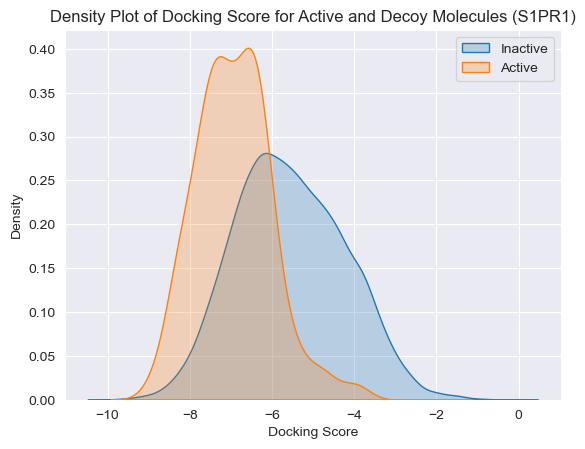

In [14]:
plot_density(all_data, title_suffix)

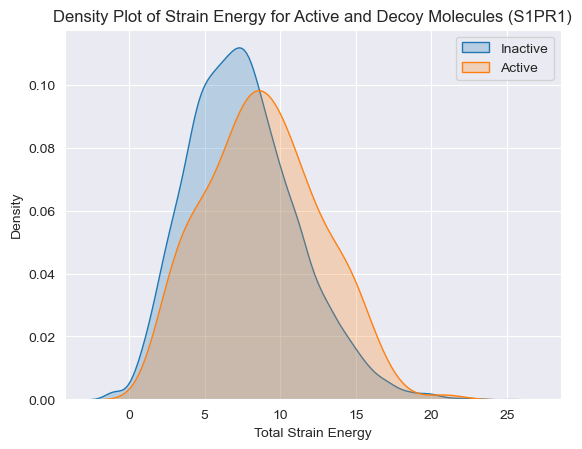

In [15]:
def plot_density_strain(df, title_suffix):
    # Hardcoded column names
    activity_col = "Activity"
    score_col = "Total_E"

    # Create a density plot for the score of active and inactive molecules
    sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label="Inactive", fill=True)
    sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label="Active", fill=True)

    # Add title and labels
    plt.title(
        f"Density Plot of Strain Energy for Active and Decoy Molecules ({title_suffix})"
    )
    plt.xlabel("Total Strain Energy")
    plt.ylabel("Density")
    plt.legend(loc="best")

    # Show the plot
    plt.show()

plot_density_strain(all_data, title_suffix)

In [16]:
def calculate_enrichment_parameters(df):
    """
    Calculates parameters we will need for Enrichment Plots

    Parameters:
    df (pandas.DataFrame): The dataframe to calculate the logAUC for.

    Returns:
    pandas.DataFrame: The dataframe with the logAUC calculated.
    """
    # Sort the subset by 'r_i_docking_score' in ascending order

    df = df.copy()

    df.sort_values(by="r_i_docking_score", inplace=True)

    # Reset the index so that we are ranking by the docking score
    df.reset_index(drop=True, inplace=True)

    # Adjusting the index to start from 1
    df.index += 1

    # Calculate the cumulative sum of active compounds
    df["Cumulative_Actives"] = df["Activity"].cumsum()

    # Calculate the Total Actives
    df["Total_Actives"] = df["Activity"].sum()

    # Calculate the fraction of identified actives at each row
    df["Fraction_Actives"] = df["Cumulative_Actives"] / df["Total_Actives"]

    # Calculate the percentage of compounds screened at each row
    df["Percentage_Screened"] = df.index / len(df)

    return df

In [17]:
all_data = calculate_enrichment_parameters(all_data)
all_data

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,C04317377_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28fba4040>,0,S1PR1_chembl19_set_decoy_sc.smi,10287,53161,0,S-OPLS,46.2507,1,C04317377_Isomer1-1,S1PR1,10285,7,-9.839130,-0.351397,-1.06705,-2.27116,-9.83913,-3.66966,-0.51143,-0,-1.93605,-32.6817,-17.4599,0.879162,-0.34808,-79.9822,-50.1416,8.97027,47,6,0,5.501254,4.234403,NaN,2,0,214,0.0,0.000109
2,C19105680_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28fba4190>,0,S1PR1_chembl19_set_decoy_sc.smi,630,53161,0,S-OPLS,23.1056,1,C19105680_Isomer1-1,S1PR1,629,9,-9.712230,-0.303507,-0.963575,-2.17483,-9.71223,-3.65966,-0.450318,-0,-1.14136,-49.6285,-14.9813,0.641197,-0.373474,-95.1118,-64.6098,12.0046,41,221,0,9.816487,8.115032,inf,6,0,214,0.0,0.000219
3,C23663588_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28fba4120>,0,S1PR1_chembl19_set_decoy_sc.smi,8841,53161,0,S-OPLS,73.0516,1,C23663588_Isomer1-1,S1PR1,8839,10,-9.656060,-0.275887,-0.902446,-2.11972,-9.65606,-4.21537,-0.227277,-0,-1.20212,-45.9255,-14.3982,0.757076,-0.312361,-89.9527,-60.3237,11.0262,142,31,0,12.740349,10.380174,NaN,9,0,214,0.0,0.000328
4,C59038567_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28fba40b0>,0,S1PR1_chembl19_set_decoy_sc.smi,1625,53161,0,S-OPLS,38.6831,1,C59038567_Isomer1-1,S1PR1,1624,10,-9.487060,-0.306034,-0.96137,-2.13962,-9.48706,-2.82232,-0.28602,-0,-2.46198,-50.2272,-12.3858,0.79367,-0.341173,-99.648,-62.6131,4.81627,142,195,0,11.616835,8.959902,NaN,10,0,214,0.0,0.000438
5,C40564286_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28fba4200>,0,S1PR1_chembl19_set_decoy_sc.smi,1717,53161,0,S-OPLS,34.0305,1,C40564286_Isomer1-1,S1PR1,1716,8,-9.485870,-0.316196,-0.982493,-2.15529,-9.48587,-3.23094,-0.664013,-0,-1.98766,-39.649,-12.1225,0.332075,-0.134512,-80.9499,-51.7715,5.3948,18,267,0,7.178073,6.224445,inf,3,0,214,0.0,0.000547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9133,C44087439_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2af631fc0>,0,S1PR1_chembl19_set_decoy_sc.smi,9518,53161,0,S-OPLS,40.2895,1,C44087439_Isomer1-1,S1PR1,9516,7,-0.936735,-0.0302172,-0.0949239,-0.211262,-0.936735,-0.461272,0,-0,1.21785,-29.7935,-4.01567,0.545657,-0.146939,-30.3382,-33.8092,10.9435,151,183,0,7.501407,6.111443,NaN,1,214,214,1.0,0.999562
9134,C08425975_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2af632030>,0,S1PR1_chembl19_set_decoy_sc.smi,5354,53161,0,S-OPLS,41.0485,1,C08425975_Isomer1-1,S1PR1,5353,7,-0.899740,-0.0290239,-0.091175,-0.202919,-0.89974,-0.561959,0,-0,-0.65469,-22.6379,7.43144,0.523094,-0.189007,-12.0263,-15.2064,6.40583,36,41,0,5.928180,4.860555,NaN,3,214,214,1.0,0.999672
9135,C02731842_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2af632110>,0,S1PR1_chembl19_set_decoy_sc.smi,21,53161,0,S-OPLS,45.1648,1,C02731842_Isomer1-1,S1PR1,20,9,-0.846404,-0.024183,-0.0791041,-0.185804,-0.846404,-0.885137,-0.0171284,-0,-0.0163354,-3.74457,-0.166603,0.411944,-0.127528,-3.52462,-3.91118,7.96294,38,209,0,12.151737,8.808483,NaN,1,214,214,1.0,0.999781
9136,C64663913_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2af632180>,0,S1PR1_chembl19_set_decoy_sc.smi,7086,53161,0,S-OPLS,39.344,1,C64663913_Isomer1-1,S1PR1,7085,7,-0.597229,-0.0199076,-0.0618577,-0.135697,-0.597229,-0.781863,-0.0701912,-0,1.01

In [18]:
total_e_thresholds = [None, 4, 4.5, 5.0, 5.5, 6.0, 7.0, 7.5, 8.0]

In [19]:
def logauc_by_strain(df, a=1e-3, total_e_threshold=None):
    # Filter dataframe based on 'Total_E' threshold if provided
    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    # Invert scores since lower scores indicate positive class
    y_scores_inverted = -df["r_i_docking_score"]

    # Calculate FPR, TPR, and thresholds using sklearn
    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    # Select the thresholds that result in FPR >= a for log scale plotting
    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    # Calculate log of FPR for valid indices
    log_fpr_valid = np.log10(fpr_valid)

    # Calculate the AUC for the valid range
    linlog_auc = auc(log_fpr_valid, tpr_valid)

    ### NOTE TIMES 10 NOTE ###
    log_auc = (linlog_auc / -np.log10(a)) * 10

    return log_auc

In [20]:
def plot_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold and plot
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]
    
    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
    
    plt.bar(range(len(thresholds)), log_aucs, tick_label=x_labels)
    plt.title(f"Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Linear Log10 AUC (x10)")
    plt.show()

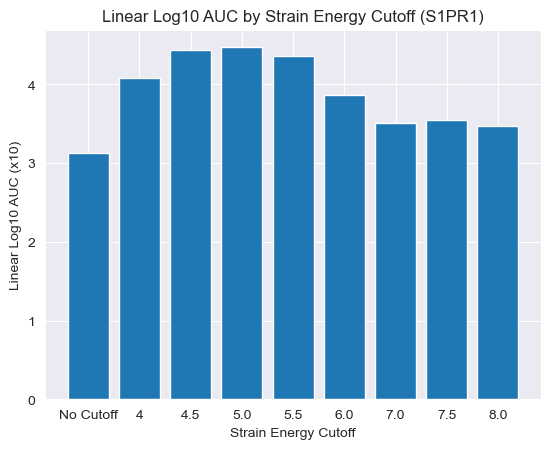

In [21]:
plot_log_aucs(all_data, total_e_thresholds, title_suffix)

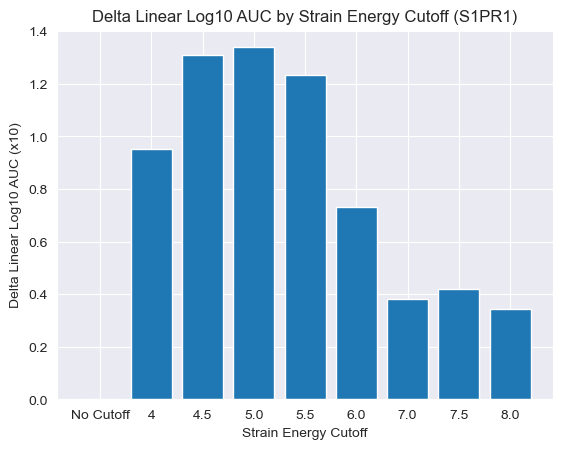

In [22]:
def plot_delta_log_aucs(data, thresholds, title_suffix):
  # Calculate log_auc for 'None' threshold
  none_log_auc = logauc_by_strain(data, total_e_threshold=None)
  
  # Calculate delta log_auc for each threshold and plot
  delta_log_aucs = [logauc_by_strain(data, total_e_threshold=t) - none_log_auc for t in thresholds]
  
  # Create labels for the x-axis
  x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
  
  plt.bar(range(len(thresholds)), delta_log_aucs, tick_label=x_labels)
  plt.title(f"Delta Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
  plt.xlabel("Strain Energy Cutoff")
  plt.ylabel("Delta Linear Log10 AUC (x10)")
  plt.show()

plot_delta_log_aucs(all_data, total_e_thresholds, title_suffix)

In [23]:
def write_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]

    delta_log_aucs = [0] + [log_aucs[i] - log_aucs[0] for i in range(1, len(log_aucs))]

    #print(f"Delta LogAUCs for {title_suffix}: {delta_log_aucs}")

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
    
    # Create a dataframe to hold the data
    df = pd.DataFrame({
        "Protein": title_suffix,
        "Strain Energy Cutoff": x_labels,
        "Linear Log10 AUC (x10)": log_aucs,
        "Delta Linear Log10 AUC (x10)": delta_log_aucs
    })
    
    # Write the dataframe to a CSV file
    df.to_csv(f"strain_log_aucs_{title_suffix}.csv", index=False)

write_log_aucs(all_data, total_e_thresholds, title_suffix)

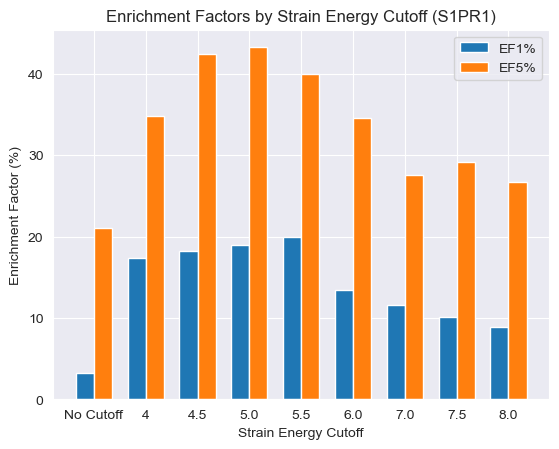

In [24]:
def enrichment_metrics_by_strain(df, total_e_threshold=None):

    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    df = calculate_enrichment_parameters(df).copy()

    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]

    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    ) * 100

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]) * 100

    # print(df.shape)

    # print(
    #     f"1% Closest Cumulative_Actives: {closest_to_one_percent['Cumulative_Actives'].values[0]}"
    # )
    # print(
    #     f"1% Closest Total_Actives: {closest_to_one_percent['Total_Actives'].values[0]}"
    # )
    # print(
    #     f"5% Closest Cumulative_Actives: {closest_to_five_percent['Cumulative_Actives'].values[0]}"
    # )
    # print(
    #     f"5% Closest Total_Actives: {closest_to_five_percent['Total_Actives'].values[0]}"
    # )

    return ef1, ef5


def bar_plot_enrichment_by_strain(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(*[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds])

    # print(f"EF1% for {title_suffix}: {ef1s}")
    # print(f"EF5% for {title_suffix}: {ef5s}")

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create an array with the positions of each bar on the x axis
    x = np.arange(len(x_labels))

    # Set the width of the bars
    bar_width = 0.35

    plt.bar(x - bar_width/2, ef1s, bar_width, label="EF1%")
    plt.bar(x + bar_width/2, ef5s, bar_width, label="EF5%")
    plt.title(f"Enrichment Factors by Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Enrichment Factor (%)")
    plt.xticks(x, x_labels)  # Set the position and labels of the xticks
    plt.legend()
    plt.show()

bar_plot_enrichment_by_strain(all_data, total_e_thresholds, title_suffix)

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_42395/2506411786.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


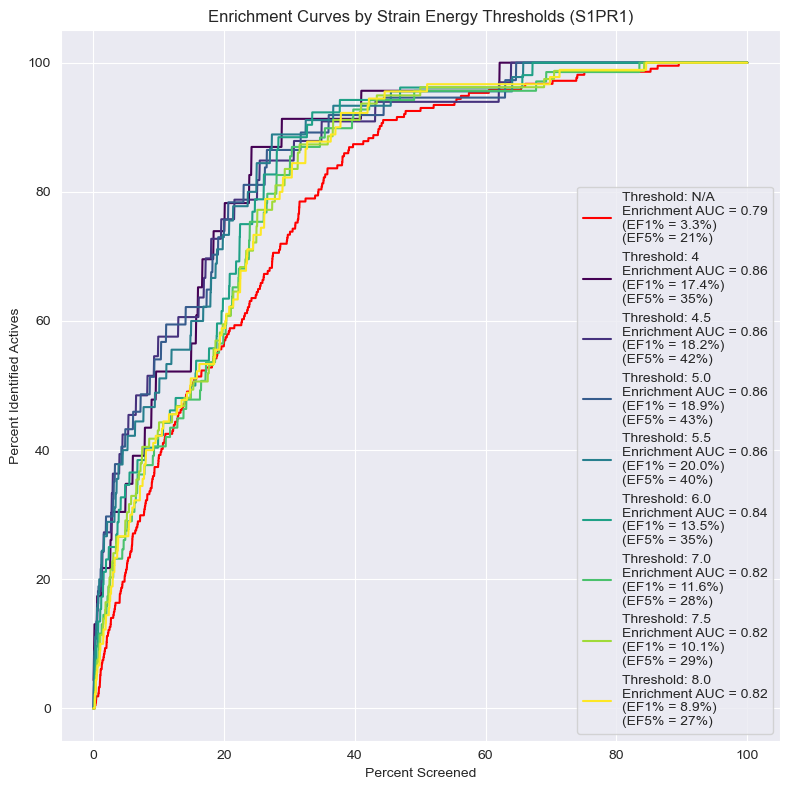

In [25]:
def plot_enrichment_curve_by_strain(df, total_e_threshold=None, ax=None, color='blue'):

    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    df = calculate_enrichment_parameters(df).copy()

    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]

    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    ) * 100

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
    ) * 100

    # Plot the enrichment curve
    ax.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label="Threshold: {}\nEnrichment AUC = {:.2f}\n(EF1% = {:.1f}%)\n(EF5% = {:.0f}%)".format(
            total_e_threshold if total_e_threshold is not None else 'N/A',
            enrichment_auc, ef1, ef5
            ),
        color=color
        )

    # # Add axis labels and title
    # plt.xlabel("Compounds Screened (%)")
    # plt.ylabel("Percent of Identified Actives (%)")
    # plt.title(f"Enrichment Curve ({title_suffix})")

    ax.legend()


def plot_enrichment_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(
        figsize=(8, 8)
        )

    # Define a colormap
    cmap = cm.get_cmap(
        "viridis", len(thresholds) - 1
    )  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Set a distinct color for the first threshold
        color = (
            "red" if t is None else cmap(i - 1)
        )  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_enrichment_curve_by_strain(df_filtered, total_e_threshold=t, ax=ax, color=color)

    ax.set_title(f"Enrichment Curves by Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("Percent Screened")
    ax.set_ylabel("Percent Identified Actives")

    plt.tight_layout()
    plt.show()

plot = plot_enrichment_all_thresholds(all_data, total_e_thresholds, title_suffix)

In [26]:
def write_enrichment_metrics(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(*[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds])

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create a dataframe to hold the data
    df = pd.DataFrame({
        "Protein": title_suffix,
        "Strain Energy Cutoff": x_labels,
        "EF1%": ef1s,
        "EF5%": ef5s
    })

    # Write the dataframe to a CSV file
    df.to_csv(f"strain_enrichment_metrics_{title_suffix}.csv", index=False)

write_enrichment_metrics(all_data, total_e_thresholds, title_suffix)

In [27]:
def plot_semi_log_roc(df, a=1e-3, total_e_threshold=None, ax=None, color='blue'):
  # Filter dataframe based on 'Total_E' threshold if provided
  if total_e_threshold is not None:
    df = df[df["Total_E"] <= total_e_threshold]

  # Invert scores since lower scores indicate positive class
  y_scores_inverted = -df["r_i_docking_score"]

  # Calculate FPR, TPR, and thresholds using sklearn
  fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

  # Select the thresholds that result in FPR >= a for log scale plotting
  valid_indices = np.where(fpr >= a)
  fpr_valid = fpr[valid_indices]
  tpr_valid = tpr[valid_indices]

  # Calculate log of FPR for valid indices
  log_fpr_valid = np.log10(fpr_valid)

  # Calculate LogAUC
  log_auc = (auc(log_fpr_valid, tpr_valid) / -np.log10(a)) * 10

  # Count the number of rows with Activity = 1 and the total number of rows
  activity_1_count = df[df["Activity"] == 1].shape[0]
  total_count = df.shape[0]

  # Plot semi-log ROC curve
  ax.plot(
    log_fpr_valid,
    tpr_valid,
    label=f"Threshold: {total_e_threshold if total_e_threshold is not None else 'N/A'}, LogAUC: {log_auc:.2f}, Actives: {activity_1_count}, Total count: {total_count}",
    color=color
  )
  ax.legend()


In [28]:
def plot_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Set a distinct color for the first threshold
        color = 'red' if t is None else cmap(i - 1)  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_semi_log_roc(df_filtered, total_e_threshold=t, ax=ax, color=color)

    ax.set_title(f"Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("log(FPR)")
    ax.set_ylabel("TPR")

    plt.tight_layout()
    plt.show()

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_42395/2145919082.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set


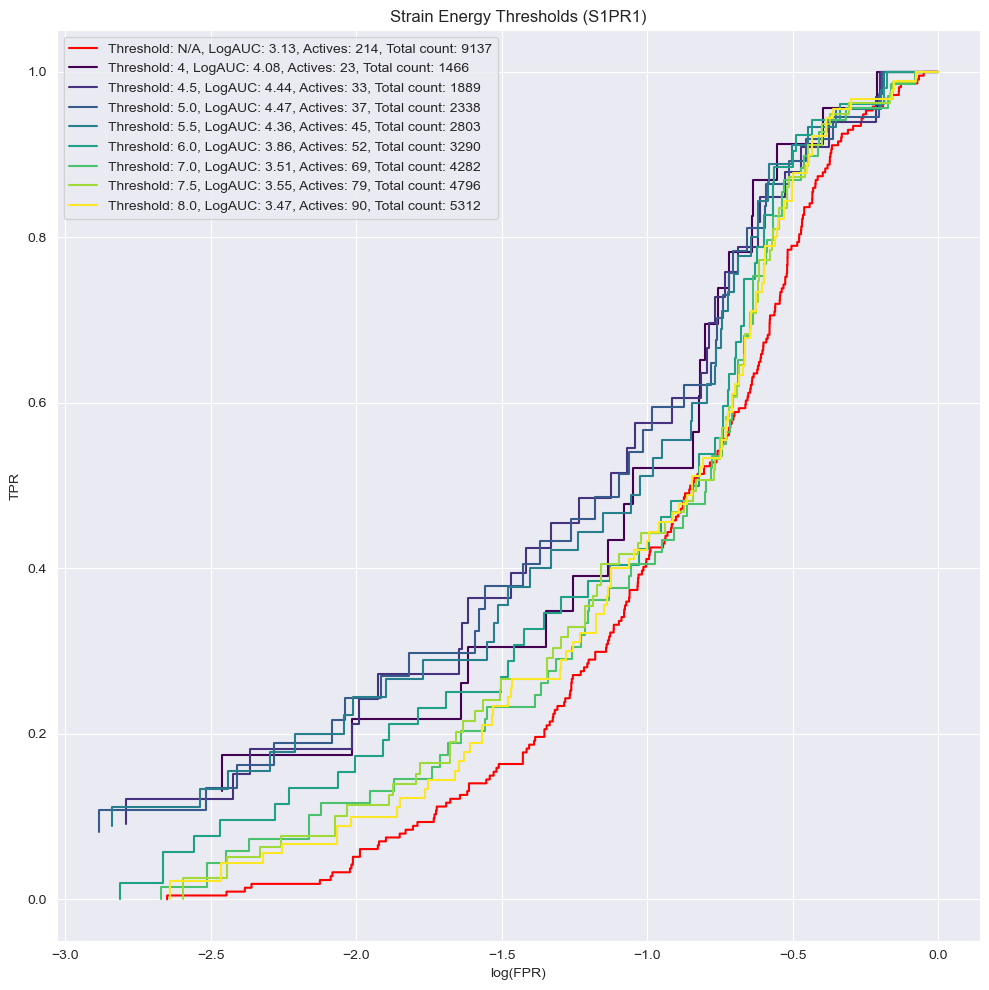

In [29]:
plot = plot_all_thresholds(all_data, total_e_thresholds, title_suffix)

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_42395/2191446731.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set


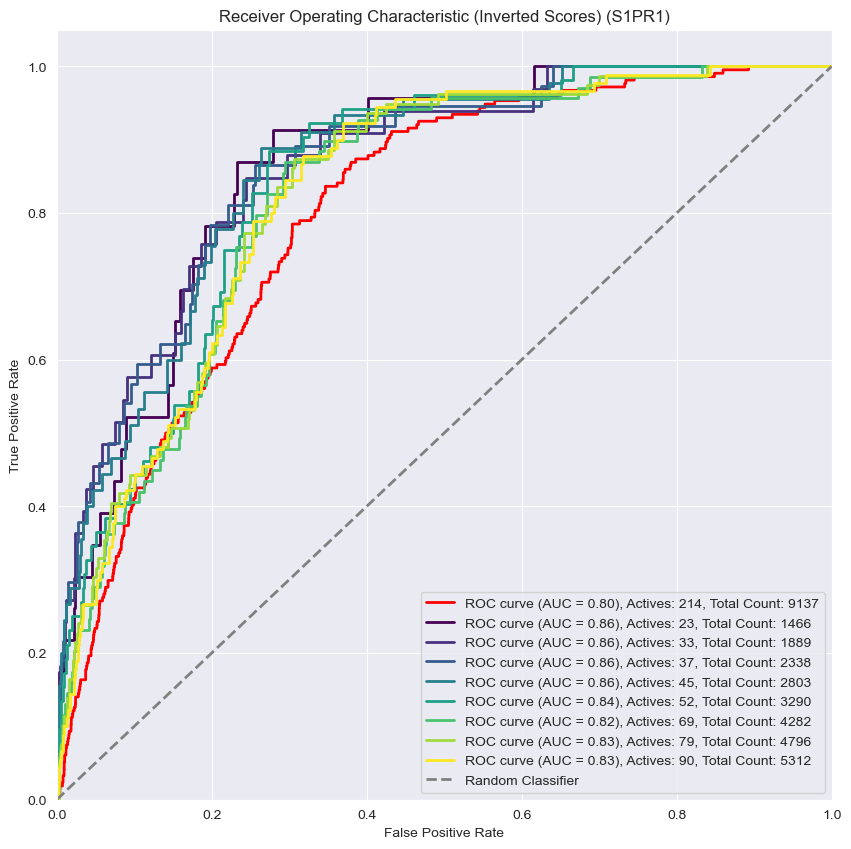

In [30]:
def plot_roc_curve_inverted(data, total_e_threshold, ax, title_suffix, color='blue'):
    """
    Plot the ROC curve for the given true labels and inverted scores.

    :param data: The DataFrame containing the data.
    :param total_e_threshold: The threshold for the 'Total_E' column. If this is not None, the data is filtered to only include rows where 'Total_E' is less than or equal to this threshold.
    :param ax: The axes object to plot on.
    :param title_suffix: The suffix to add to the title of the plot.
    :param color: The color to use for the ROC curve.
    """
    # Filter the data based on 'Total_E' threshold
    df = data if total_e_threshold is None else data[data["Total_E"] <= total_e_threshold]

    # Get the true labels and scores
    y_true = df["Activity"]
    y_scores = df["r_i_docking_score"]

    # Inverting the scores
    y_scores_inverted = -y_scores

    # Compute the ROC curve and AUC with inverted scores
    fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
    roc_auc = auc(fpr, tpr)

    # Count the number of rows with Activity = 1 and the total number of rows
    activity_1_count = df[df["Activity"] == 1].shape[0]
    total_count = df.shape[0]

    # Plotting the ROC curve
    ax.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f}), Actives: {activity_1_count}, Total Count: {total_count}", color=color)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"Receiver Operating Characteristic (Inverted Scores) ({title_suffix})")

def plot_roc_curves_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set

    # Plot ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Set a distinct color for the first threshold
        color = 'red' if t is None else cmap(i - 1)  # Subtract 1 because the first color is manually set

        plot_roc_curve_inverted(
            data,
            total_e_threshold=t,
            ax=ax,
            title_suffix=title_suffix,
            color=color
        )

    # Plot the random classifier line after all the ROC curves
    ax.plot([0, 1], [0, 1], lw=2, linestyle="--", label="Random Classifier", color="grey")

    ax.legend()

    plt.show()

plot_roc_curves_all_thresholds(all_data, total_e_thresholds, title_suffix)

In [31]:
def write_roc_metrics(data, thresholds, title_suffix):
    # Create a list to hold the data
    data_list = []

    # Loop over each threshold
    for t in thresholds:
        # Filter the data based on 'Total_E' threshold
        df = data if t is None else data[data["Total_E"] <= t]

        # Get the true labels and scores
        y_true = df["Activity"]
        y_scores = df["r_i_docking_score"]

        # Inverting the scores
        y_scores_inverted = -y_scores

        # Compute the ROC curve and AUC with inverted scores
        fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
        roc_auc = auc(fpr, tpr)

        # Count the number of rows with Activity = 1 and the total number of rows
        activity_1_count = df[df["Activity"] == 1].shape[0]
        total_count = df.shape[0]

        # Add the data to the list
        data_list.append({
            "Protein": title_suffix,
            "Strain Energy Cutoff": t if t is not None else 'No Cutoff',
            "ROC_AUC": roc_auc,
            "Actives": activity_1_count,
            "Total Count": total_count
        })

    # Create a dataframe from the list
    df = pd.DataFrame(data_list)

    # Write the dataframe to a CSV file
    df.to_csv(f"strain_roc_metrics_{title_suffix}.csv", index=False)

write_roc_metrics(all_data, total_e_thresholds, title_suffix)

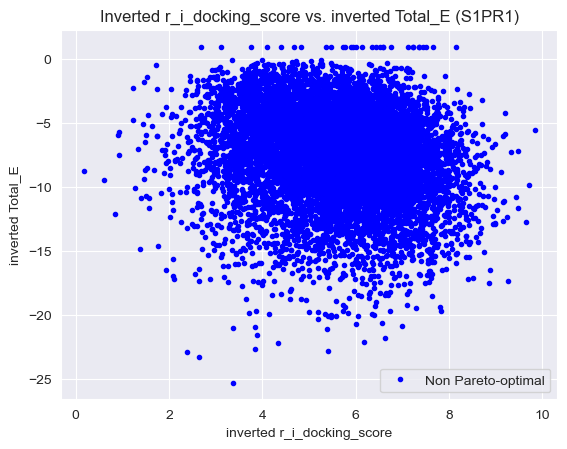

In [32]:
import oapackage

df = all_data

# Invert the scores for optimization
df["inverted_docking_score"] = -df["r_i_docking_score"]
df["inverted_Total_E"] = -df["Total_E"]

plt.plot(
    df["inverted_docking_score"],
    df["inverted_Total_E"],
    ".b",
    label="Non Pareto-optimal",
)
plt.title(f"Inverted r_i_docking_score vs. inverted Total_E ({title_suffix})")
plt.xlabel("inverted r_i_docking_score")
plt.ylabel("inverted Total_E")
plt.legend()
plt.show()

Pareto: 6 optimal values, 6 objects


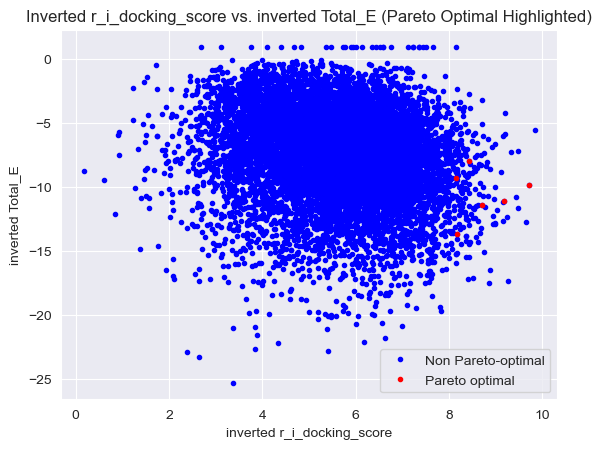

In [33]:
pareto = oapackage.ParetoDoubleLong()

# Use the inverted scores for Pareto optimization
for index, row in df.iterrows():
    w = oapackage.doubleVector((row["inverted_docking_score"], row["inverted_Total_E"]))
    pareto.addvalue(w, index)

pareto.show(verbose=1)
# Retrieve the indices of Pareto optimal points
lst = pareto.allindices()

# Convert the list of indices to a format suitable for DataFrame indexing
index_list = [int(x) for x in lst]  # Ensure indices are in integer format

# Select Pareto optimal points from the DataFrame using the corrected indices
optimal_datapoints = df.iloc[index_list]

# Re-plot the initial data for context
plt.plot(
    df["inverted_docking_score"],
    df["inverted_Total_E"],
    ".b",
    label="Non Pareto-optimal",
)

# Plot Pareto optimal points
plt.plot(
    optimal_datapoints["inverted_docking_score"],
    optimal_datapoints["inverted_Total_E"],
    ".r",
    label="Pareto optimal",
)

plt.title(
    f"Inverted r_i_docking_score vs. inverted Total_E (Pareto Optimal Highlighted)"
)
plt.xlabel("inverted r_i_docking_score")
plt.ylabel("inverted Total_E")
plt.legend()
plt.show()

In [34]:
display(optimal_datapoints)

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened,inverted_docking_score,inverted_Total_E
2,C19105680_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28fba4190>,0,S1PR1_chembl19_set_decoy_sc.smi,630,53161,0,S-OPLS,23.1056,1,C19105680_Isomer1-1,S1PR1,629,9,-9.71223,-0.303507,-0.963575,-2.17483,-9.71223,-3.65966,-0.450318,-0,-1.14136,-49.6285,-14.9813,0.641197,-0.373474,-95.1118,-64.6098,12.0046,41,221,0,9.816487,8.115032,inf,6,0,214,0.000000,0.000219,9.71223,-9.816487
12,C14536690_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28fba42e0>,0,S1PR1_chembl19_set_decoy_sc.smi,5214,53161,0,S-OPLS,49.2939,1,C14536690_Isomer1-1,S1PR1,5213,10,-9.17831,-0.254953,-0.841837,-2.00246,-9.17831,-3.46676,-0.413497,-0,-0.615619,-58.4067,-13.5155,0.733351,-0.468129,-111.693,-71.9222,9.22534,149,243,0,11.060275,7.088173,NaN,5,0,214,0.000000,0.001313,9.17831,-11.060275
41,C24624787_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28fba5070>,0,S1PR1_chembl19_set_decoy_sc.smi,2060,53161,0,S-OPLS,29.4078,1,C24624787_Isomer1-1,S1PR1,2059,11,-8.70054,-0.255898,-0.829011,-1.92219,-8.70054,-3.81125,-0.514859,-0,-0.977587,-37.6923,-12.1067,0.766658,-0.462882,-46.2277,-49.7989,22.4641,464,353,0,11.440566,8.045848,NaN,4,3,214,0.014019,0.004487,8.70054,-11.440566
80,C58840465_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28fba6030>,0,S1PR1_chembl19_set_decoy_sc.smi,5236,53161,0,S-OPLS,29.5245,1,C58840465_Isomer1-1,S1PR1,5235,9,-8.43363,-0.272053,-0.854621,-1.90204,-8.43363,-2.75416,-0.745744,-0,-1.09896,-55.1935,-10.1637,0.634438,-0.184973,-96.8433,-65.3572,3.94966,72,291,0,7.968813,6.660887,10.364728,6,6,214,0.028037,0.008756,8.43363,-7.968813
158,C39959601_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28fba7d10>,0,S1PR1_chembl19_set_decoy_sc.smi,10292,53161,0,S-OPLS,45.6654,1,C39959601_Isomer1-1,S1PR1,10290,9,-8.17826,-0.302898,-0.908695,-1.90376,-8.17826,-3.26544,-0.562858,-0,-1.38994,-36.7577,-9.91156,0.717853,-0.353251,-62.1572,-46.6692,12.9995,16,302,0,13.669180,10.412053,NaN,1,18,214,0.084112,0.017292,8.17826,-13.669180
170,C03264075_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a1220200>,0,S1PR1_chembl19_set_decoy_sc.smi,4351,53161,0,S-OPLS,27.7934,1,C03264075_Isomer1-1,S1PR1,4350,11,-8.15410,-0.281176,-0.863862,-1.86708,-8.1541,-3.59739,-0.488455,-0,-1.3873,-50.1295,-7.09689,1.08172,-0.191679,-81.5331,-57.2264,6.40887,29,229,0,9.296172,7.469612,NaN,3,20,214,0.093458,0.018606,8.15410,-9.296172
